In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [5]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(autoload_with=engine)

In [6]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [7]:
# Save references to each table
# Measurement class
Measurement = Base.classes.measurement
# Station class
Station = Base.classes.station

In [8]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [9]:
# Find the most recent date in the data set.
mostRecent_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
# Display the date
print(mostRecent_date[0])

2017-08-23


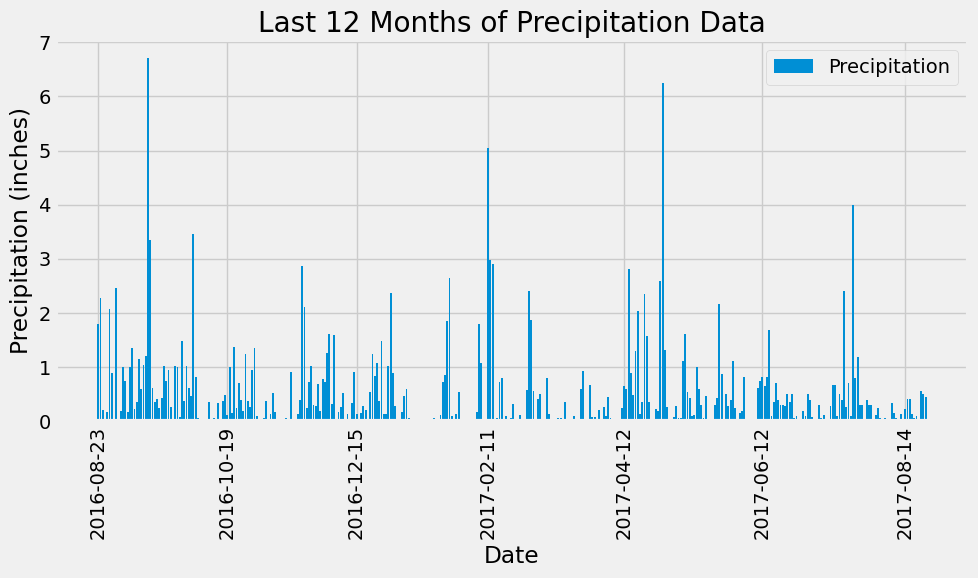

In [10]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database.
# Extract the date from the tuple
mostRecent_date = mostRecent_date[0]

# Convert the most recent date from string to datetime format
mostRecent_date = dt.datetime.strptime(mostRecent_date, '%Y-%m-%d').date()

# Calculate the date one year ago from the last date in the dataset
one_year_ago = mostRecent_date - dt.timedelta(days=365)

# Perform a query to retrieve the data and precipitation scores
precipitation_data = session.query(Measurement.date, Measurement.prcp).\
    filter(Measurement.date >= one_year_ago).filter(Measurement.date <= mostRecent_date).all()

# Save the query results as a Pandas DataFrame. Explicitly set the column names
precipitation_df = pd.DataFrame(precipitation_data, columns=['Date', 'Precipitation'])

# Sort the dataframe by date
precipitation_df.set_index('Date', inplace=True)
precipitation_df = precipitation_df.sort_index()

# Use Pandas Plotting with Matplotlib to plot the data
plt.figure(figsize=(10, 6))
plt.bar(precipitation_df.index, precipitation_df['Precipitation'], label='Precipitation')
plt.xlabel('Date')
plt.ylabel('Precipitation (inches)')
plt.title('Last 12 Months of Precipitation Data')
plt.xticks(precipitation_df.index[::365], rotation=90)
plt.legend()
plt.tight_layout()
plt.show()

In [11]:
# Use Pandas to calculate the summary statistics for the precipitation data
summary_stats = precipitation_df['Precipitation'].describe()
summary_stats

count    2021.000000
mean        0.177279
std         0.461190
min         0.000000
25%         0.000000
50%         0.020000
75%         0.130000
max         6.700000
Name: Precipitation, dtype: float64

# Exploratory Station Analysis

In [12]:
# Design a query to calculate the total number of stations in the dataset
total_stations = session.query(func.count(Station.station)).scalar()
# Display the total stations
print(f"There are {total_stations} stations.")

There are 9 stations.


In [13]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
active_stations = session.query(Measurement.station, func.count(Measurement.station)).\
                    group_by(Measurement.station).\
                    order_by(func.count(Measurement.station).desc()).all()
# Loop to display the results in a readable format
for station, count in active_stations:
    print(f"Station ID: {station}, Obs. Count: {count}")

Station ID: USC00519281, Obs. Count: 2772
Station ID: USC00519397, Obs. Count: 2724
Station ID: USC00513117, Obs. Count: 2709
Station ID: USC00519523, Obs. Count: 2669
Station ID: USC00516128, Obs. Count: 2612
Station ID: USC00514830, Obs. Count: 2202
Station ID: USC00511918, Obs. Count: 1979
Station ID: USC00517948, Obs. Count: 1372
Station ID: USC00518838, Obs. Count: 511


In [14]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
most_active_station = active_stations[0][0]

# Query to calculate the lowest, highest, and average temperature for the most active station
temp_stats = session.query(func.min(Measurement.tobs),
                           func.max(Measurement.tobs),
                           func.avg(Measurement.tobs)).\
                filter(Measurement.station == most_active_station).all()

# Display the lowest, highest, and average temperature for the most active station
lowest_temp, highest_temp, avg_temp = temp_stats[0]
print(f"Most Active Station ID: {most_active_station}")
print(f"Lowest Temperature: {lowest_temp}")
print(f"Highest Temperature: {highest_temp}")
print(f"Average Temperature: {avg_temp:.2f}")

Most Active Station ID: USC00519281
Lowest Temperature: 54.0
Highest Temperature: 85.0
Average Temperature: 71.66


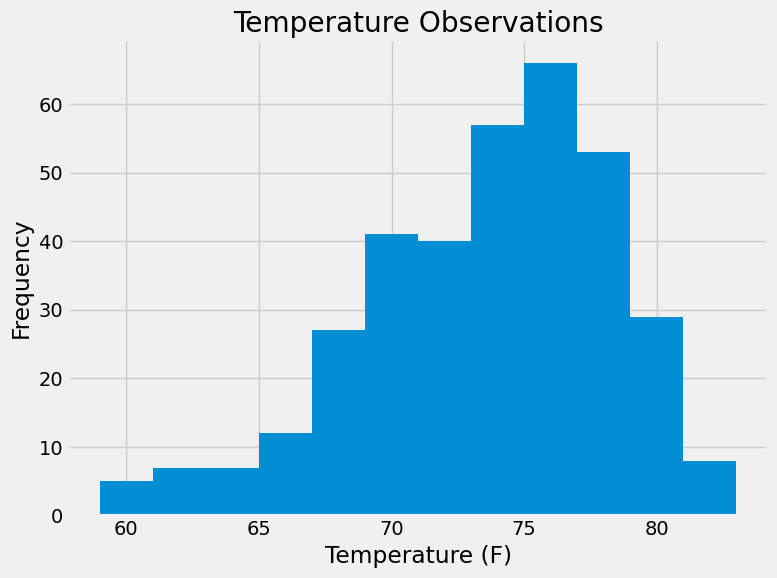

In [15]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
temp_data = session.query(Measurement.tobs).\
                filter(Measurement.station == most_active_station).\
                filter(Measurement.date >= one_year_ago).\
                filter(Measurement.date <= mostRecent_date).all()

# Convert query results to a list
temps = [temp[0] for temp in temp_data]

# Plot the results as a histogram
plt.figure(figsize=(8, 6))
plt.hist(temps, bins=12)
plt.xlabel('Temperature (F)')
plt.ylabel('Frequency')
plt.title('Temperature Observations')
plt.tight_layout()
plt.show()

# Close Session

In [16]:
# Close Session
session.close()